In [ ]:
# Install basic packages
!pip install -q numpy torch torchvision matplotlib pillow tqdm h5py n2v csbdeep timm opencv-python scikit-image

# Clone DPIR repo (DnCNN and FFDNet)
!git clone https://github.com/cszn/DPIR.git dpir_repo || echo "Already cloned"

# Download pretrained models using curl
!mkdir -p dpir_repo/model_zoo
!curl -L -o dpir_repo/model_zoo/dncnn_sigma25.pth https://github.com/cszn/DPIR/releases/download/v1.0/dncnn_sigma25.pth
!curl -L -o dpir_repo/model_zoo/ffdnet_color_sigma25.pth https://github.com/cszn/DPIR/releases/download/v1.0/ffdnet_color_sigma25.pth

# Clone Restormer repo
!git clone https://github.com/swz30/Restormer.git restormer_repo || echo "Already cloned"

# Download Restormer pretrained weights
!curl -L -o restormer_repo/Restormer_Denoising.pth https://github.com/swz30/Restormer/releases/download/v1.0/Restormer_Denoising.pth

print("✅ Everything is now installed.")

Cloning into 'dpir_repo'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 239 (delta 48), reused 35 (delta 35), pack-reused 179 (from 1)
Receiving objects: 100% (239/239), 6.85 MiB | 3.03 MiB/s, done.
Resolving deltas: 100% (104/104), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0    103      0 --:--:-- --:--:-- --:--:--   104
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0    117      0 --:--:-- --:--:-- --:--:--   118
Cloning into 'restormer_repo'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (51/51), done.
remote: Tota

In [55]:
import numpy as np
import torch
from typing import Union, Dict
from PIL import Image

def denoise_image(img: Union[np.ndarray, str], method: str, params: Dict = {}) -> np.ndarray:
    """
    Denoise an image using a specified deep learning method.

    Parameters:
        img (np.ndarray or str): Input image or path to image file.
        method (str): Name of the denoising method.
        params (dict): Method-specific parameters (e.g., noise_level for DnCNN).

    Returns:
        np.ndarray: Denoised image in [0, 1] range.
    """
    if isinstance(img, str):
        img = np.array(Image.open(img).convert('RGB')) / 255.0
    elif isinstance(img, np.ndarray):
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img /= 255.0
    else:
        raise ValueError("Input must be a numpy array or file path")

    if method.lower() == 'dncnn':
        return _denoise_dncnn(img, **params)
    elif method.lower() == 'ffdnet':
        return _denoise_ffdnet(img, **params)
    elif method.lower() == 'noise2void':
        return _denoise_n2v(img, **params)
    elif method.lower() == 'restormer':
        return _denoise_restormer(img, **params)
    else:
        raise ValueError(f"Unknown denoising method: {method}")

# -------------------- Method Implementations --------------------

def _denoise_dncnn(img, noise_level=25):
    import models.dncnn as dncnn  # Make sure you clone https://github.com/cszn/DnCNN
    model = dncnn.load_pretrained_model(noise_level)
    return model(img)

def _denoise_ffdnet(img, noise_level=25):
    import models.ffdnet as ffdnet  # Clone https://github.com/cszn/FFDNet
    model = ffdnet.load_pretrained_model(noise_level)
    return model(img)

def _denoise_n2v(img, model_path='n2v_model.zip'):
    from n2v.models import N2V
    model = N2V(config=None, name='n2v_model', basedir='.')
    model.load_weights(model_path)
    return model.predict(img)

def _denoise_restormer(img, model_path='Restormer.pth'):
    from models.restormer import Restormer, load_image
    model = Restormer.load_pretrained(model_path)
    return model(img)



In [56]:
import cripser
import persim

def compute_diagram(img):
    """Compute and split PH diagram by homological dimension."""
    ph = cripser.computePH(img)
    return [ph[ph[:, 0] == d, 1:3] for d in range(2)]

def bottleneck_distance(diag1, diag2):
    return max(
        persim.bottleneck(diag1[0], diag2[0]),
        persim.bottleneck(diag1[1], diag2[1])
    )

def count_small_intervals(diag, epsilon):
    count = 0
    for dgm in diag:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        count += np.sum(lifetimes <= epsilon)
    return int(count)

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import cripser
import persim

def compute_diagram(img):
    """Compute and split PH diagram by homological dimension."""
    ph = cripser.computePH(img)
    return [ph[ph[:, 0] == d, 1:3] for d in range(2)]

def bottleneck_distance(diag1, diag2):
    return max(
        persim.bottleneck(diag1[0], diag2[0]),
        persim.bottleneck(diag1[1], diag2[1])
    )

def count_small_intervals(diag, epsilon):
    count = 0
    for dgm in diag:
        lifetimes = dgm[:, 1] - dgm[:, 0]
        count += np.sum(lifetimes <= epsilon)
    return int(count)

def plot_image_and_diagram(original, imgs, names, epsilon=0.1, save_as=None, figsize=None):
    if not isinstance(imgs, (list, tuple, np.ndarray)):
        imgs = [imgs]

    n = len(imgs)
    n_cols = min(n, 4)
    n_rows = int(np.ceil(n / n_cols))

    print(n_rows, n_cols)

    # Default figsize
    if figsize is None:
        figsize = ((11/3) * n_cols, 7 * n_rows)

    fig, axs = plt.subplots(n_rows * 2, n_cols, figsize=figsize)
    axs = np.array(axs).reshape(n_rows * 2, n_cols)

    original_diag = compute_diagram(original)

    for idx, img in enumerate(imgs):
        row, col = divmod(idx, n_cols)

        diag = compute_diagram(img)
        supnorm = np.max(np.abs(img - original))
        bdist = bottleneck_distance(diag, original_diag)
        small_count = count_small_intervals(diag, epsilon)

        # Plot image
        ax_img = axs[2 * row, col]
        ax_img.imshow(img, cmap='inferno', vmin=0, vmax=1)
        ax_img.axis('off')
        ax_img.set_title(f"{names[idx]}\nsupnorm = {supnorm:.3f}")

        # Plot persistence diagram
        ax_diag = axs[2 * row + 1, col]
        persim.plot_diagrams(diag, ax=ax_diag, lifetime=False, diagonal=True)

        # Add threshold line parallel to the diagonal: y = x + ε
        lims = ax_diag.get_xlim()
        x_vals = np.linspace(*lims, 200)
        y_vals = x_vals + epsilon
        ax_diag.plot(x_vals, y_vals, color='red', linestyle='--', label=f'ε = {epsilon}')
        ax_diag.set_xlim(*lims)  # Reset xlim because persim might auto-rescale
        ax_diag.set_ylim(*lims)  # Match ylim to xlim for square view

        ax_diag.legend()
        ax_diag.set_title(f"Bottleneck = {bdist:.3f}\ntopological noise = {small_count}")

    # # Remove unused subplots to tighten layout
    # total_slots = n_rows * n_cols
    # for idx in range(n, total_slots):
    #     axs[2 * (idx // n_cols), idx % n_cols].remove()
    #     axs[2 * (idx // n_cols) + 1, idx % n_cols].remove()


    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    plt.show()


1 1


/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]


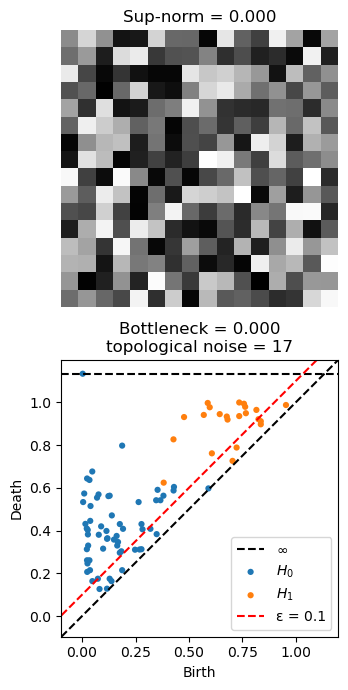

In [58]:
# original image
original = np.random.rand(16, 16)

# filtered images
images = [original] + [original + 0.01 * np.random.randn(16, 16) for _ in range(0)]

plot_image_and_diagram(original, images, epsilon=0.1,figsize=None, save_as="comparison.pdf")


In [16]:
!curl -L -o dpir_repo/model_zoo/dncnn_sigma25.pth \
  https://github.com/cszn/DPIR/releases/download/v1.0/dncnn_sigma25.pth


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0     23      0 --:--:-- --:--:-- --:--:--    23


In [59]:
import persim, cripser

In [60]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize
import sys
import os
import persim

# Load and preprocess image
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24))
filtered_images = {"original": image}

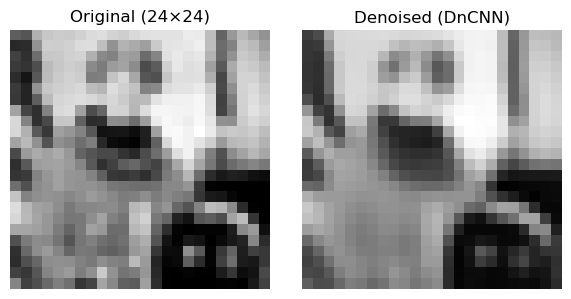

In [61]:
# Add dpir_repo to path so we can import models
sys.path.append(os.path.abspath("dpir_repo"))

# Load DnCNN model from dpir_repo
def load_dncnn_model():
    from models.network_dncnn import DnCNN as DnCNN_net
    model = DnCNN_net(in_nc=1, out_nc=1, nc=64, nb=17, act_mode='R')
    weights = torch.load('dpir_repo/model_zoo/dncnn_25.pth', map_location='cpu', weights_only=False)
    model.load_state_dict(weights)
    model.eval()
    return model

# Apply model to image
def apply_dncnn(image, model):
    img_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        denoised = model(img_tensor).clamp(0, 1)
    return denoised.squeeze().numpy()

# Load and run
dncnn_model = load_dncnn_model()
denoised_image = apply_dncnn(image, dncnn_model)
filtered_images["dncnn_25"] = denoised_image

# Plot result
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original (24×24)")
axs[0].axis('off')

axs[1].imshow(denoised_image, cmap='gray')
axs[1].set_title("Denoised (DnCNN)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [62]:
list(filtered_images.keys())

['original', 'dncnn_25']

In [63]:
imgs = list(filtered_images.values())
original = imgs[0]

1 2


/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]


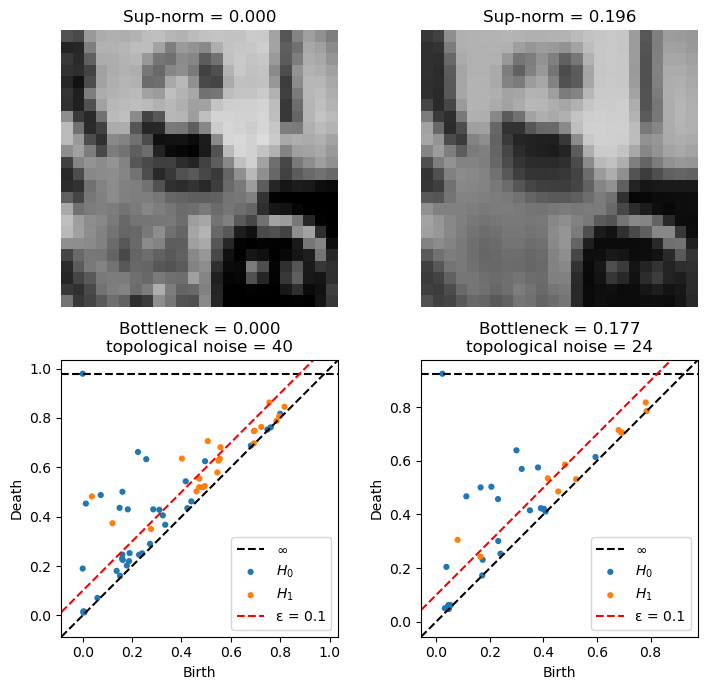

In [64]:
plot_image_and_diagram(original, imgs, epsilon=0.1)

In [26]:
!curl -L -o dpir_repo/models/network_ffdnet.py \
  https://raw.githubusercontent.com/cszn/FFDNet/master/models/network_ffdnet.py


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     43      0 --:--:-- --:--:-- --:--:--    43


In [30]:
!git clone https://github.com/JingyunLiang/SwinIR.git

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 2.83 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [66]:
import sys
sys.path.append('SwinIR/models')  # Modify this to match your cloned path
from network_swinir import SwinIR

/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### SwinIR (sigma = 15)

/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


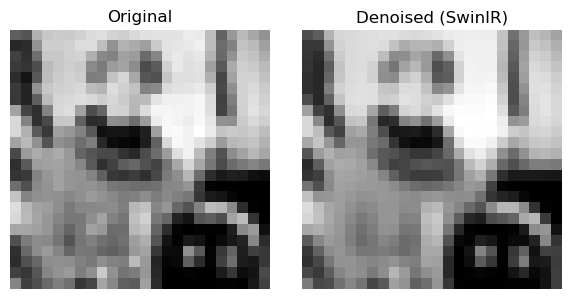

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize
from PIL import Image

# --- Load and preprocess image ---
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Convert to tensor (B,C,H,W)
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # (1, 1, 24, 24)

# Resize to nearest multiple of 8 (SwinIR requirement)
h, w = img_tensor.shape[-2:]
h_pad = (8 - h % 8) % 8
w_pad = (8 - w % 8) % 8
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()


model = SwinIR(
    upscale=1,
    in_chans=1,
    img_size=128,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6, 6, 6],  # 6 blocks per stage (SwinIR-M)
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='',
    resi_connection='1conv'
)


# Load pretrained weights (Gaussian σ=15 grayscale)
loadnet = torch.load('SwinIR/model_zoo/004_grayDN_DFWB_s128w8_SwinIR-M_noise15.pth')
model.load_state_dict(loadnet['params'], strict=True)
model.eval()

# --- Run inference ---
with torch.no_grad():
    denoised = model(img_tensor).clamp(0, 1)

# --- Crop padding ---
denoised = denoised[..., :h, :w].squeeze().cpu().numpy()
filtered_images["swinir_15"] = denoised

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(denoised, cmap='gray')
axs[1].set_title("Denoised (SwinIR)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

### SwinIR (sigma = 25)

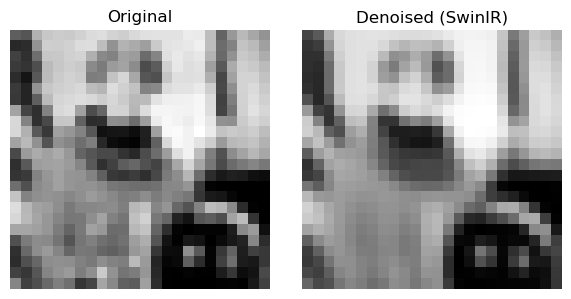

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize
from PIL import Image

# --- Load and preprocess image ---
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Convert to tensor (B,C,H,W)
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # (1, 1, 24, 24)

# Resize to nearest multiple of 8 (SwinIR requirement)
h, w = img_tensor.shape[-2:]
h_pad = (8 - h % 8) % 8
w_pad = (8 - w % 8) % 8
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()


model = SwinIR(
    upscale=1,
    in_chans=1,
    img_size=128,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6, 6, 6],  # 6 blocks per stage (SwinIR-M)
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='',
    resi_connection='1conv'
)


# Load pretrained weights (Gaussian σ=15 grayscale)
loadnet = torch.load('SwinIR/model_zoo/004_grayDN_DFWB_s128w8_SwinIR-M_noise25.pth')
model.load_state_dict(loadnet['params'], strict=True)
model.eval()

# --- Run inference ---
with torch.no_grad():
    denoised = model(img_tensor).clamp(0, 1)

# --- Crop padding ---
denoised = denoised[..., :h, :w].squeeze().cpu().numpy()
filtered_images["swinir_25"] = denoised

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(denoised, cmap='gray')
axs[1].set_title("Denoised (SwinIR)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

### SwinIR (sigma = 50)

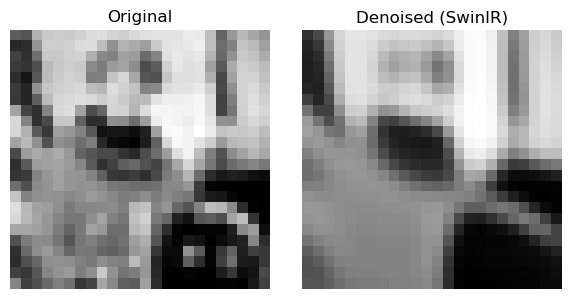

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize
from PIL import Image

# --- Load and preprocess image ---
image = color.rgb2gray(data.astronaut())
image = resize(image, (24, 24), anti_aliasing=True)

# Convert to tensor (B,C,H,W)
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # (1, 1, 24, 24)

# Resize to nearest multiple of 8 (SwinIR requirement)
h, w = img_tensor.shape[-2:]
h_pad = (8 - h % 8) % 8
w_pad = (8 - w % 8) % 8
img_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()


model = SwinIR(
    upscale=1,
    in_chans=1,
    img_size=128,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6, 6, 6],  # 6 blocks per stage (SwinIR-M)
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='',
    resi_connection='1conv'
)


# Load pretrained weights (Gaussian σ=15 grayscale)
loadnet = torch.load('SwinIR/model_zoo/004_grayDN_DFWB_s128w8_SwinIR-M_noise50.pth')
model.load_state_dict(loadnet['params'], strict=True)
model.eval()

# --- Run inference ---
with torch.no_grad():
    denoised = model(img_tensor).clamp(0, 1)

# --- Crop padding ---
denoised = denoised[..., :h, :w].squeeze().cpu().numpy()
filtered_images["swinir_50"] = denoised

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(denoised, cmap='gray')
axs[1].set_title("Denoised (SwinIR)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

2 4


/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.f

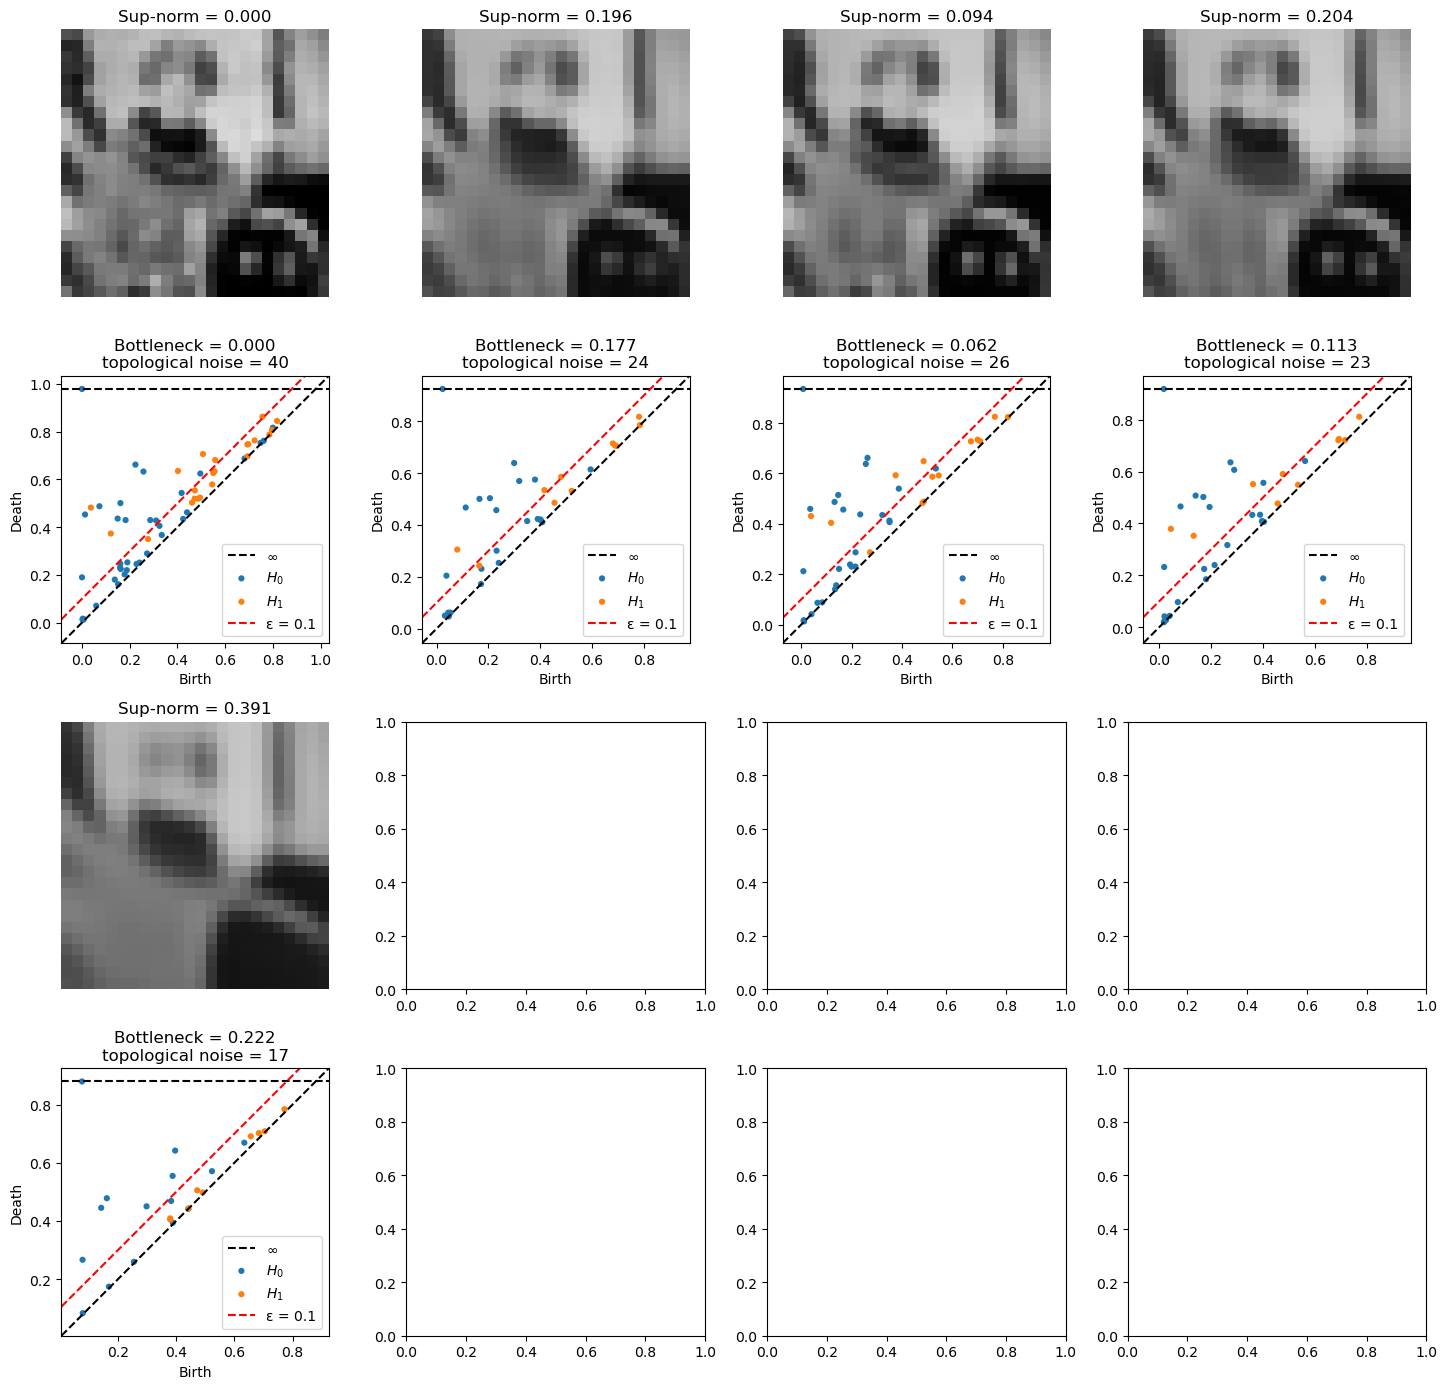

In [70]:
images = list(filtered_images.values())
original = images[0]
plot_image_and_diagram(original, images, epsilon=0.1)

# KBNet

In [93]:
!git clone https://github.com/zhangyi-3/KBNet
!pip install -r KBNet/requirements.txt

fatal: destination path 'KBNet' already exists and is not an empty directory.


In [71]:
from basicsr.models.archs.kbnet_s_arch import KBNet_s
import torch
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize
import torch.nn.functional as F


In [77]:
def denoise_kbnet(image, yaml_path):
    # Load config
    with open(yaml_path, "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    model_config = config["network_g"]
    model_config.pop("type", None)

    model = KBNet_s(**model_config)

    # Load checkpoint
    ckpt_path = 'KBNet/Denoising/' + config['path']['pretrain_network_g']
    checkpoint = torch.load(ckpt_path, map_location='cpu')

    def strip_module_prefix(state_dict):
        return {k.replace('module.', ''): v for k, v in state_dict.items()}

    state_dict = checkpoint.get('params') or checkpoint.get('net') or checkpoint
    state_dict = strip_module_prefix(state_dict)

    missing, unexpected = model.load_state_dict(state_dict, strict=False)

    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)

    tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
    tensor = tensor.cuda() if torch.cuda.is_available() else tensor

    # Step 3: Pad to multiple of 8
    H, W = image.shape
    pad_h = (8 - H % 8) % 8
    pad_w = (8 - W % 8) % 8
    tensor_padded = F.pad(tensor, (0, pad_w, 0, pad_h), mode='reflect')

    # Step 4: Apply the model
    with torch.no_grad():
        output = model(tensor_padded)
    output = output[..., :H, :W].squeeze().cpu().numpy()

    return output

In [ ]:
image_float32 = image.astype(np.float32)

# KBNet denoising sigma = 15
yaml_path = "KBNet/Denoising/Options/gau_gray_15.yml"
denoised_kbnet = denoise_kbnet(image_float32, yaml_path)
filtered_images["kbnet_15"] = denoised_kbnet

# KBNet denoising sigma = 25
yaml_path = "KBNet/Denoising/Options/gau_gray_25.yml"
denoised_kbnet = denoise_kbnet(image_float32, yaml_path)
filtered_images["kbnet_25"] = denoised_kbnet

Missing keys: []
Unexpected keys: []
Missing keys: []
Unexpected keys: []
Missing keys: []
Unexpected keys: []


2 4


/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
/Users/2021mac-002/anaconda3/envs/test-lpf/lib/python3.12/site-packages/persim/visuals.py:87: RuntimeWarning: overflow encountered in cast
  diagrams = [dgm.astype(np.f

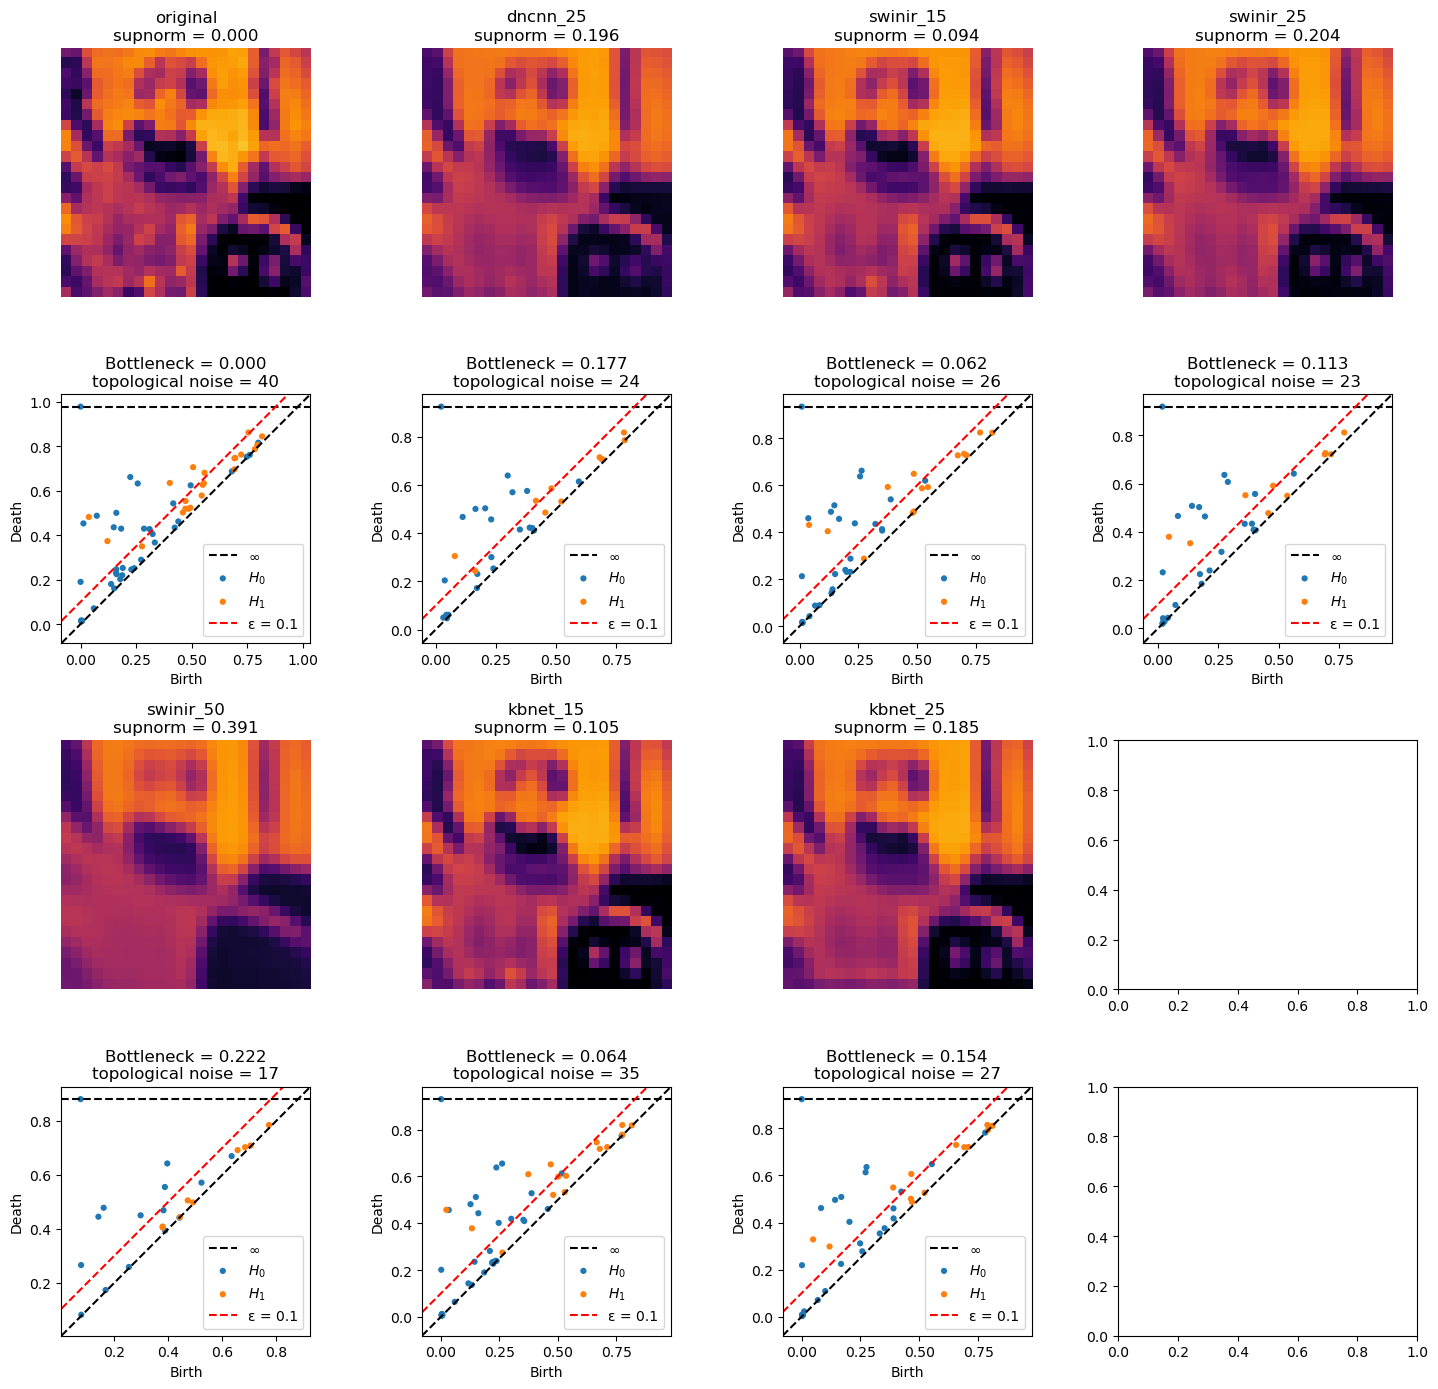

In [92]:
images = list(filtered_images.values())
names = list(filtered_images.keys())
original = images[0]
plot_image_and_diagram(original, images, names, epsilon=0.1)